In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [3]:
words = open('data/names.txt').read().splitlines()
words = list(w.lower() for w in words)
len(words)

21985

In [12]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
block_size = 3
vocab_size = len(stoi)

In [9]:
def build_dataset(words):
    X,Y = [],[]
    context = [0]*block_size
    for w in words:
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [11]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([125725, 3]) torch.Size([125725])
torch.Size([16100, 3]) torch.Size([16100])
torch.Size([15535, 3]) torch.Size([15535])


In [27]:
n_emb = 10
n_hidden = 200

C = torch.randn((vocab_size, n_emb))
W1 = torch.randn((n_emb*block_size, n_hidden)) * (5/3)/((n_emb * block_size)**0.5)
# b1 = torch.randn(n_hidden) * 0
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print('total params: ', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

total params:  12730


In [29]:
batch_size = 32
max_steps = 200000
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact-bnmeani)/bnstdi+bnbias
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.001
    for p in parameters:
        p.data += -lr*p.grad
        
    if i%10000==0:
        print(f'{i}/{max_steps}, loss:{loss.item():.4f}')
    lossi.append(loss.log10().item())

0/200000, loss:3.3858
10000/200000, loss:2.7203
20000/200000, loss:2.6779
30000/200000, loss:2.4910
40000/200000, loss:2.3609
50000/200000, loss:2.4546
60000/200000, loss:2.6440
70000/200000, loss:2.2570
80000/200000, loss:2.5402
90000/200000, loss:2.3324
100000/200000, loss:2.0268
110000/200000, loss:2.1141
120000/200000, loss:2.0083
130000/200000, loss:2.4298
140000/200000, loss:2.1889
150000/200000, loss:2.0937
160000/200000, loss:1.8692
170000/200000, loss:2.0202
180000/200000, loss:2.2238
190000/200000, loss:1.9614


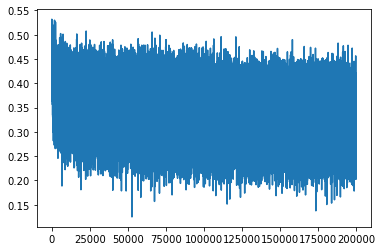

In [33]:
plt.plot(lossi);

In [38]:
with torch.no_grad():
    emb = C[Xtr]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat@W1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [43]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1
    hpreact = bngain * (hpreact-bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.110860586166382
val 3.067075490951538


In [55]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))/fan_in**0.5
        self.bias = None
        if bias:
            self.bias = torch.zeros(fan_out)
    
    def __call__(self, x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [bias])

In [60]:
class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [64]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [65]:
n_emb = 10
n_hidden = 100

C = torch.randn((vocab_size, n_emb))
layers = [
    Linear(n_emb*block_size, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1D(vocab_size)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print('total params:', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

total params: 47360


In [195]:
max_steps = 2000000
batch_size = 32 
losses = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for l in layers:
        x = l(x)
    loss = F.cross_entropy(x, Yb)
    
    for l in layers:
        l.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    if i%10000==0:
        print(f"{i}/{max_steps}, loss: {loss.item(): .4f}")
    losses.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std()/p.data.std()).log10().item() for p in parameters])
    
    if i>1000:
        break

0/2000000, loss:  2.5088


torch.Size([32, 100])
layer 2: Tanh,        m:-0.004372188821434975, std:0.6348458528518677 saturation:3.375000238418579%
torch.Size([32, 100])
layer 5: Tanh,        m:0.0005352577427402139, std:0.6543981432914734 saturation:2.75%
torch.Size([32, 100])
layer 8: Tanh,        m:-0.0040680114179849625, std:0.6596105694770813 saturation:2.5%
torch.Size([32, 100])
layer 11: Tanh,        m:0.001430863980203867, std:0.6646146178245544 saturation:2.09375%
torch.Size([32, 100])
layer 14: Tanh,        m:-0.005581161007285118, std:0.6688112020492554 saturation:1.71875%


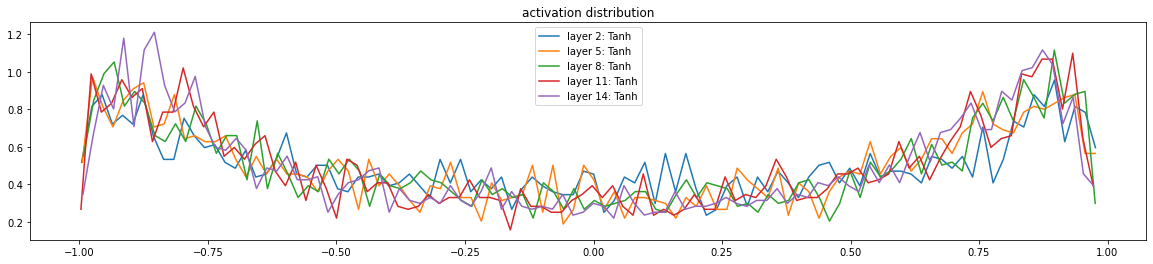

In [196]:
plt.figure(figsize=(20, 4));
legends =[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(t.shape)
        print(f"layer {i}: {layer.__class__.__name__},\
        m:{t.mean()}, std:{t.std()} saturation:{(t.abs() > 0.97).float().mean()*100}%")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i}: {layer.__class__.__name__}")
plt.legend(legends);     
plt.title('activation distribution');

layer 2 (Tanh)
m:-4.656612768993984e-12, std:0.0022387367207556963
layer 5 (Tanh)
m:8.149072562579907e-12, std:0.0021756619680672884
layer 8 (Tanh)
m:-1.5133991282390014e-11, std:0.002228295896202326
layer 11 (Tanh)
m:1.105945543478093e-11, std:0.0021296606864780188
layer 14 (Tanh)
m:4.074536281289953e-12, std:0.002065758453682065


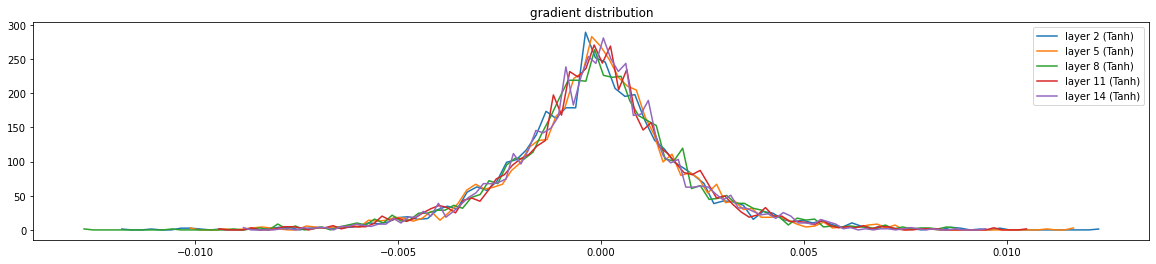

In [197]:
plt.figure(figsize=(20, 4));
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        print(f"layer {i} ({layer.__class__.__name__})")
        t = layer.out.grad
        print(f"m:{t.mean()}, std:{t.std()}")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title('gradient distribution');

weight:torch.Size([30, 10]) | m -1.1175870645585562e-10 | std 0.008150766603648663 | grad:data ratio 0.008497294038534164
weight:torch.Size([30, 100]) | m -6.999357719905674e-05 | std 0.009070177562534809 | grad:data ratio 0.046517256647348404
weight:torch.Size([100, 100]) | m 2.826752643159125e-05 | std 0.005189418327063322 | grad:data ratio 0.047200996428728104
weight:torch.Size([100, 100]) | m 3.8966256397543475e-05 | std 0.005389823112636805 | grad:data ratio 0.04978238791227341
weight:torch.Size([100, 100]) | m -4.1095227061305195e-05 | std 0.0054967026226222515 | grad:data ratio 0.051269035786390305
weight:torch.Size([100, 100]) | m 9.115447755903006e-05 | std 0.005730023141950369 | grad:data ratio 0.054047759622335434
weight:torch.Size([100, 30]) | m -0.0001437753380741924 | std 0.010989921167492867 | grad:data ratio 0.0917254164814949


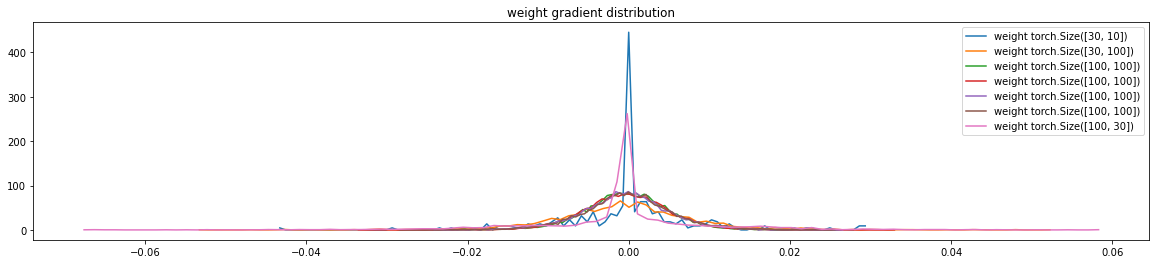

In [198]:
plt.figure(figsize=(20, 4));
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f"weight:{p.shape} | m {t.mean()} | std {t.std()} | grad:data ratio {t.std()/p.std()}")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"weight {p.shape}")
plt.legend(legends)
plt.title('weight gradient distribution');

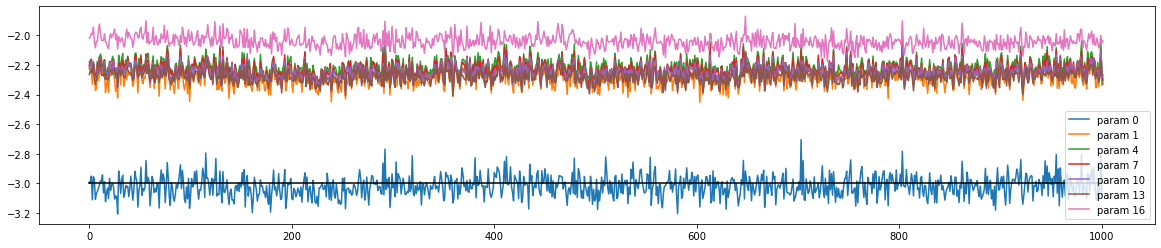

In [206]:
plt.figure(figsize=(20, 4));
legends = []
for i,p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {i}")

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

In [208]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for l in layers:
        x = l(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())
    
for layer in layers:
    layer.training = False

split_loss('train')
split_loss('val')

train 2.3203821182250977
val 2.9916739463806152


In [213]:
for _ in range(20):
    context = [0]*block_size
    out = []
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for l in layers:
            x = l(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        out.append(itos[ix])
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(out))

ccris.
geusgider.
rittonnianucenda.
azina.
pagopinta.
ata.
licoericy.
nite.
mauna.
domanie.
raana.
kit.
lonareh.
wlo.
hay.
lamann.
qre.
paufe.
rechy.
pocila.


In [217]:
import scipy.stats as stats

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


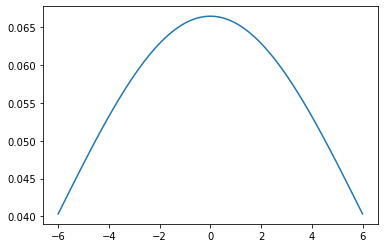

In [230]:
k = torch.linspace(-6, 6, 100)
plt.plot(k, stats.norm.pdf(k,))

In [262]:
from ipywidgets import interact

def normshow(x0):
    x  = torch.randn(5)*5
    x[0] = x0
    xmean = x.mean()
    xstd = x.std()
    y = (x - xmean)/xstd
    
    plt.figure(figsize=(10, 5))
    plt.plot([-6, 6], [0, 0], 'k')
    xx = torch.linspace(-6, 6, 1000)
    plt.plot(xx, stats.norm.pdf(xx, xmean, xstd), 'b')
    xx = torch.linspace(-6, 6, 1000)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
    
    for i in range(len(x)):
        plt.plot([x[i], y[i]], [1, 0], 'k', alpha=0.2)
        
    plt.scatter(x.data, torch.ones_like(x.data), c='b', s=100)
    plt.scatter(y.data, torch.ones_like(y.data), c='r', s=100)
    plt.title(f'input mu {xmean}, std {xstd}')
    
    
interact(normshow, x0=(-30, 30, 0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [269]:
n = 10000
a = torch.randn((n, 1), requires_grad=True)
w = torch.randn((n, n), requires_grad=True)
c = w@a
loss = torch.randn(n)@c
a.retain_grad()
w.retain_grad()
c.retain_grad()
loss.backward()
print('a', a.data.std())
print('w', w.data.std())
print('c', c.data.std())
print('---------')
print('a.grad', a.grad.std())
print('w.grad', w.grad.std())
print('c.grad', c.grad.std())

a tensor(1.0046)
w tensor(1.0000)
c tensor(100.3078)
---------
a.grad tensor(101.1415)
w.grad tensor(1.0128)
c.grad tensor(1.0081)


In [272]:
n = 10000
a = torch.randn((n, 1), requires_grad=True)
w = torch.randn((n, n), requires_grad=True)
c = w@a
xmean = c.mean()
xstd = c.std()
out = (c-xmean)/(xstd+1e-5)

loss = torch.randn(n)@out
a.retain_grad()
w.retain_grad()
c.retain_grad()
out.retain_grad()
loss.backward()
print('a', a.data.std())
print('w', w.data.std())
print('c', c.data.std())
print('o', out.data.std())
print('---------')
print('a.grad', a.grad.std())
print('w.grad', w.grad.std())
print('c.grad', c.grad.std())
print('o.grad', out.grad.std())

a tensor(0.9911)
w tensor(0.9998)
c tensor(97.9984)
o tensor(1.0000)
---------
a.grad tensor(1.0334)
w.grad tensor(0.0102)
c.grad tensor(0.0103)
o.grad tensor(1.0087)
